# Project Description

The purpose of this project is to find answers to some important questions about drugs for certain conditions. Some of these questions are "what are the top 5 conditions mentioned in the dataset", "significant best and worst rated drugs for these top 5 conditions", "no of reviews per year", "top reviewed drugs". The dataset was cleaned prior to performing EDA. Text preprocessing steps included removal of stop words and punctuation. Reviews were transformed to a bag of words representation. Multinomial NB was used to perform sentimental analysis for the reviews. Reviews with a rating of 10 were considered as positive reviews and rating of 0 were considered as negative reviews. Confusion matrix, ROC-AUC score were used to evaluate the model.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import random
import os
import seaborn as sns

In [5]:
#Exception handling method to open the data file
path = '../data/'

file = os.path.join(path,"drugsComTest_raw.csv")

try:
    df = pd.read_csv(file)
except FileNotFoundError as err:
    print("Please enter a valid file location: ",err)

# Data Dictionary

In [6]:
#Creating a Data Dictionary for the drug review dataset.

dtype=[]
unique_items=[]
for i in df.columns:
    dtype.append(df[i].dtype)
    unique_items.append(len(df[i].unique()))
data_dict=pd.DataFrame({'Dtype':dtype,
              'No.of unique items':unique_items,
               'Description':["Reviewer's unique identification number",
                              "Name of the drug that is reviewed",
                              "Condition that is being treated with the drug",
                              "Text of the review",
                              "Drug rating on a scale of 1(worst) to 10(best)",
                              "Review publish date",
                              "A measure for the usefulness of a review"]},
               index = ['uniqueID','drugName','condition','review','rating','date','usefulCount'])
data_dict

Dtype  No.of unique items  \
uniqueID      int64               53766   
drugName     object                2637   
condition    object                 709   
review       object               48280   
rating        int64                  10   
date         object                3566   
usefulCount   int64                 325   

                                                Description  
uniqueID            Reviewer's unique identification number  
drugName                  Name of the drug that is reviewed  
condition     Condition that is being treated with the drug  
review                                   Text of the review  
rating       Drug rating on a scale of 1(worst) to 10(best)  
date                                    Review publish date  
usefulCount        A measure for the usefulness of a review

# Data Cleaning

In [7]:
#Check for Null values in the columns

df.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [8]:
#Drop the rows where the 'condition' is Nan

nan_rows=df[df['condition'].isnull()]
df=df.drop(nan_rows.index)

In [9]:
#Data cleaning: Eliminated instances of '&#039;' from 'review'

df['review']=df['review'].str.replace('&#039;','')
df.head()

uniqueID         drugName                     condition  \
0    163740      Mirtazapine                    Depression   
1    206473       Mesalamine  Crohn's Disease, Maintenance   
2    159672          Bactrim       Urinary Tract Infection   
3     39293         Contrave                   Weight Loss   
4     97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "Ive tried a few antidepressants over the year...      10  28-Feb-12   
1  "My son has Crohns disease and has done very w...       8  17-May-09   
2                      "Quick reduction of symptoms"       9  29-Sep-17   
3  "Contrave combines drugs that were used for al...       9   5-Mar-17   
4  "I have been on this birth control for one cyc...       9  22-Oct-15   

   usefulCount  
0           22  
1           17  
2            3  
3           35  
4            4

In [10]:
#Drop the column uniqueID

df=df.drop(columns='uniqueID')

In [11]:
#Eliminated instances of '\r\r\n' in the reviews

df['review']=df['review'].str.replace('\r\r\n','')
df.reset_index(drop=True,inplace=True)

In [12]:
#Delete the rows which contain " users found this comment helpful" in the condition column.

#Boolean masking to select the bad rows

bad_rows=df[df.condition.str.contains(r'\d+</span> users found this comment helpful.',na=False)] 
df.drop(df.index[bad_rows.index], inplace=True)

#Reset the index

df.reset_index(drop=True,inplace=True)

# Descriptive Analysis

In [13]:
print("Number of entries in the Dataframe: {:>5d}".format(df.shape[0]))
print("Number of columns: {:22d}".format(df.shape[1]))

Number of entries in the Dataframe: 53200
Number of columns:                      6


In [14]:
df.describe()

rating   usefulCount
count  53200.000000  53200.000000
mean       6.978289     28.170282
std        3.286389     36.284596
min        1.000000      0.000000
25%        4.000000      6.000000
50%        8.000000     16.000000
75%       10.000000     36.000000
max       10.000000    949.000000

In [15]:
#Find the top 5 conditions

top_5_condt=df['condition'].value_counts().nlargest(5)
print("The top 5 reviewed conditions are: \n")
print("Condition\t\tNo.of Reviews")
for i,z in enumerate(top_5_condt):
    print('{:20s} {:>16d}'.format(top_5_condt.index[i],z))

The top 5 reviewed conditions are: 

Condition		No.of Reviews
Birth Control                    9648
Depression                       3095
Pain                             2100
Anxiety                          1908
Acne                             1847


In [16]:
#Extract the rows with the top 5 conditions

final_df=df[df['condition'].apply(lambda x:True if x in top_5_condt.index else False)]
final_df.reset_index(drop=True,inplace=True)

#Display the first 10 rows
final_df.head(10)

drugName      condition  \
0            Mirtazapine     Depression   
1        Cyclafem 1 / 35  Birth Control   
2                 Copper  Birth Control   
3                 Levora  Birth Control   
4  Microgestin Fe 1 / 20           Acne   
5      Blisovi Fe 1 / 20  Birth Control   
6             Duloxetine           Pain   
7               NuvaRing  Birth Control   
8           Escitalopram     Depression   
9                  Aubra  Birth Control   

                                              review  rating       date  \
0  "Ive tried a few antidepressants over the year...      10  28-Feb-12   
1  "I have been on this birth control for one cyc...       9  22-Oct-15   
2  "Ive had the copper coil for about 3 months no...       6   6-Jun-16   
3  "I was on this pill for almost two years. It d...       2  16-Apr-11   
4  "So I was on Ginanvi for about 3 months before...       3  22-Jun-17   
5  "I absolutely love this product and recommend ...      10   3-Nov-17   
6  "Been on 30mg Cymbalta for 2 weeks. Started ge...       9  27-Mar-12   
7  "I was on this for 5 years (and birth control ...       7  17-Jun-11   
8  "I am a 22 year old female college student. I ...       9  29-Apr-14   
9  "Im absolutely DONE taking this horrible birth...       1  13-Dec-15   

   usefulCount  
0           22  
1            4  
2            1  
3            3  
4            1  
5            4  
6           32  
7            0  
8           32  
9            6

In [18]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18598 entries, 0 to 18597
Data columns (total 6 columns):
drugName       18598 non-null object
condition      18598 non-null object
review         18598 non-null object
rating         18598 non-null int64
date           18598 non-null object
usefulCount    18598 non-null int64
dtypes: int64(2), object(4)
memory usage: 871.9+ KB


In [19]:
#Rare conditions: Conditions which have been mentioned less than 5 times

print("Rare conditions are: \n")
conditions=df['condition'].value_counts()
for i in conditions[conditions<=5].index:
    print(i)

Rare conditions are: 

Dyspareunia
Lennox-Gastaut Syndrome
Influenza Prophylaxis
COPD, Acute
Peptic Ulce
Cyclic Vomiting Syndrome
Infection Prophylaxis
Burning Mouth Syndrome
Chronic Pancreatitis
Mucositis
Anal Fissure and Fistula
Hyperlipoproteinemia Type IIa, Elevated LDL
Condylomata Acuminata
Noninfectious Colitis
Hyperphosphatemia of Renal Failure
Nasal Polyps
Labor Pain
Biliary Cirrhosis
Breast Cancer, Prevention
Labor Induction
Gingivitis
Diabetic Kidney Disease
Non-Hodgkin's Lymphoma
Dysautonomia
Vitamin B12 Deficiency
Herbal Supplementation
Opioid Overdose
Gastrointestinal Stromal Tum
min / saxagliptin)
Pe
Mycobacterium avium-intracellulare, Treatment
Primary Ovarian Failure
Mountain Sickness / Altitude Sickness
eve
Occipital Neuralgia
Sarcoidosis
Reversal of Opioid Sedation
llicle Stimulation
Lactation Augmentation
Ventricular Tachycardia
Spondyloarthritis
Anal Itching
Dystonia
Atrophic Urethritis
Osteolytic Bone Lesions of Multiple Myeloma
Bone infection
Anemia, Sickle Cell
P

In [20]:
#Display the review which received the highest number of usefulcount

usefulcounts=df['usefulCount'].values #Convert 'usefulCount' into a ndarray
df.loc[df.usefulCount==np.max(usefulcounts)]
print(df.loc[df.usefulCount==np.max(usefulcounts)]['review'].iloc[0])

"Ive been on Zoloft 50mg for over two years. I am a more relaxed and easy-going person because of Zoloft.  Prior to starting the medicine, I was anxious all the time, worried constantly about everything, and suffered periods of depression and hopelessness.  Now I am a better wife, friend, and person in general."


# Significant drugs with the best and worst ratings

A significant number of reviews is when the number of a reviews for a drug is in the 80% quantile of the total 
number of reviews for a particular condition


In [21]:
#Find the significant drugs based on the reviews:

#A significant number of reviews is when the number of a reviews for a drug is in the 80% quantile of the total 
#number of reviews for a particular condition

#Define a function that uses quantiles to filter the reviews.
def quantile_group(df,value=0.80):
    quantile_value = df.quantile(value)
    return df[df>=quantile_value]

#Find the number of times each drug is reviewed
f=final_df.groupby('condition')['drugName'].value_counts()

#Apply quantile_group() to filter the drugs with most number of reviews
significant_drugs=f.groupby(level=0,group_keys=False).apply(quantile_group)

#Convert the resulting series into a dataframe
s=pd.DataFrame({'No.of reviews':significant_drugs.values,
              'drugName':significant_drugs.index.get_level_values(1),
              'condition':significant_drugs.index.get_level_values(0)})
p=pd.merge(s,final_df,how='inner',left_on=['condition','drugName'],right_on=['condition','drugName'])

#Find the average ratings for these drugs
m=p.groupby(['condition','drugName']).agg({'rating':np.mean,'No.of reviews':'first',})

#Find the top 10 significant "best" and "worst" drugs for each condition
sig_best=m.groupby(level=0,group_keys=False).apply(lambda x : x.nlargest(10,'rating'))
sig_worst=m.groupby(level=0,group_keys=False).apply(lambda x : x.nsmallest(10,'rating'))

In [22]:
#Top 10 significant drugs with the best rating, for the 5 conditions

sig_best

rating  No.of reviews
condition     drugName                                                   
Acne          Benzoyl peroxide / clindamycin      8.425532             94
              Accutane                            8.390909            110
              Isotretinoin                        8.266667            165
              Spironolactone                      8.083333             60
              Sulfamethoxazole / trimethoprim     8.062500             32
              Tretinoin                           7.986842             76
              Epiduo                              7.921348             89
              Differin                            7.785714             42
              Duac                                7.750000             40
              Clindamycin / tretinoin             7.656250             32
Anxiety       Xanax                               8.826087             92
              Alprazolam                          8.689394            132
              Diazepam                            8.490909             55
              Clonazepam                          8.426471            136
              Klonopin                            8.327273             55
              Gabapentin                          8.298507             67
              Lorazepam                           8.152542            118
              Lexapro                             8.126126            111
              Ativan                              8.120690             58
              Escitalopram                        7.605405            185
Birth Control Ortho Evra                          7.277778             72
              Skyla                               7.206349            252
              Mirena                              7.050704            355
              Ethinyl estradiol / norelgestromin  7.037037            135
              Levonorgestrel                      6.976159            755
              ParaGard                            6.935714            140
              Copper                              6.720207            193
              Ethinyl estradiol / etonogestrel    6.714286            196
              Loestrin 24 Fe                      6.468750             96
              Implanon                            6.453865            401
Depression    Lexapro                             8.098039            102
              Mirtazapine                         7.586667             75
              Bupropion                           7.464646            198
              Celexa                              7.410256             78
              Escitalopram                        7.407407            135
              Fluoxetine                          7.393258             89
              Wellbutrin                          7.380435             92
              Prozac                              7.303030             66
              Pristiq                             7.257353            136
              Citalopram                          7.176000            125
Pain          Acetaminophen / oxycodone           8.938596            114
              Methadone                           8.871795             39
              OxyContin                           8.816327             49
              Hydromorphone                       8.803030             66
              Lortab                              8.800000             20
              Oxycodone                           8.777778             99
              Vicodin                             8.480000             25
              Percocet                            8.432432             37
              Hydrocodone / ibuprofen             8.350000             20
              Dilaudid                            8.245283             53

In [23]:
#Top 10 significant drugs with the worst rating, for the 5 conditions

sig_worst

rating  No.of reviews
condition     drugName                                                   
Acne          Ethinyl estradiol / norethindrone   3.500000             40
              Ethinyl estradiol / norgestimate    5.836364             55
              Minocycline                         6.188119            101
              Adapalene                           6.629032             62
              Doxycycline                         7.014388            139
              Drospirenone / ethinyl estradiol    7.117647             68
              Adapalene / benzoyl peroxide        7.246667            150
              Aczone                              7.358974             39
              Dapsone                             7.586957             46
              Clindamycin / tretinoin             7.656250             32
Anxiety       Hydroxyzine                         6.074766            107
              BuSpar                              6.285714             70
              Buspirone                           6.824427            131
              Duloxetine                          7.183673             49
              Escitalopram                        7.605405            185
              Ativan                              8.120690             58
              Lexapro                             8.126126            111
              Lorazepam                           8.152542            118
              Gabapentin                          8.298507             67
              Klonopin                            8.327273             55
Birth Control Norethindrone                       5.292929             99
              Nexplanon                           5.561308            734
              Ethinyl estradiol / norethindrone   5.610215            744
              Medroxyprogesterone                 5.675325            154
              Drospirenone / ethinyl estradiol    5.693252            163
              Ethinyl estradiol / norgestimate    5.702128            517
              Ethinyl estradiol / levonorgestrel  5.755424            507
              Depo-Provera                        5.759740            154
              Sprintec                            5.801205            166
              Desogestrel / ethinyl estradiol     5.826087            161
Depression    Effexor                             5.600000             65
              Viibryd                             5.955357            112
              Vortioxetine                        6.097345            113
              Duloxetine                          6.311927            109
              Venlafaxine                         6.737226            137
              Zoloft                              6.914286            105
              Cymbalta                            6.953704            108
              Desvenlafaxine                      6.968553            159
              Vilazodone                          7.054348             92
              Sertraline                          7.078431            204
Pain          Tylenol with Codeine #3             4.148148             27
              Hysingla ER                         4.173913             23
              Lidocaine                           4.250000             24
              Acetaminophen / codeine             4.666667             24
              Nucynta                             5.785714             42
              Hydrocodone                         6.250000             20
              Tramadol                            6.368056            144
              Ultram                              6.482759             29
              Ketorolac                           6.886792             53
              Gabapentin                          6.936508             63

# Predictive Analysis

In [24]:
#Perform binary classification to predict if a review is positive or negative
#Extracting the reviews which have rating == 1 or rating == 10

classify_f=final_df[(final_df['rating']==1)|(final_df['rating']==10)]
X=classify_f['review']
Y=classify_f['rating']

X.reset_index(drop=True,inplace=True)
Y.reset_index(drop=True,inplace=True)


In [25]:
Y = Y.replace(1,0)
Y = Y.replace(10,1)

In [26]:
#Transforming the text into a vector using bag of words approach

def process_text(sentence):
    nopunc=re.sub(r'[^a-zA-z]',' ',sentence)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
vectorizer = CountVectorizer(analyzer=process_text).fit(X)

In [27]:
X=vectorizer.transform(X)

In [28]:
#Splitting the data into train and test data. Test size is 30% of the dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [29]:
#Training a Multinomial Naive Bayes model

nb = MultinomialNB()
model=nb.fit(X_train,Y_train)

In [30]:
#Predicting the rating using the test data

preds = nb.predict(X_test)

In [31]:
#Evaluating the predictions

print(confusion_matrix(Y_test,preds))
print(classification_report(Y_test,preds))

[[ 544  166]
 [  93 1379]]
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       710
           1       0.89      0.94      0.91      1472

    accuracy                           0.88      2182
   macro avg       0.87      0.85      0.86      2182
weighted avg       0.88      0.88      0.88      2182



In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [33]:
probs = nb.predict_proba(X_test)[:,1]

In [34]:
sns.set_style("darkgrid")

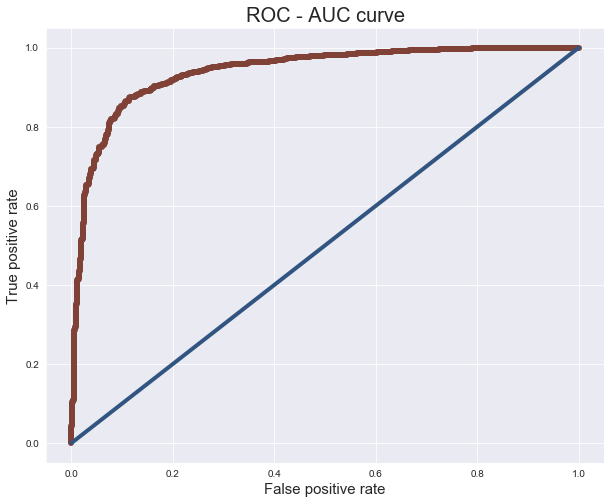

In [35]:
fpr, tpr, thresholds = roc_curve(Y_test,probs)

plt.figure(figsize = (10,8))
plt.plot(fpr,tpr,'-', color = '#804137',linewidth = 6)
plt.plot([0.0,1.0],[0.0,1.0],color = '#315580',linewidth = 4)
plt.title("ROC - AUC curve",fontsize = 20)
plt.xlabel("False positive rate",fontsize = 15)
plt.ylabel("True positive rate",fontsize = 15)
plt.show()

In [36]:
print('AUC SCORE : {:.4}'.format(auc(fpr,tpr)))

AUC SCORE : 0.9393


# Test Cases

In [37]:
classify_f.rating.replace(1,0,inplace = True)
classify_f.rating.replace(10,1,inplace = True)

/Users/poojadeshpande91/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [38]:
#Testing the model using a test function

def test(args):
        
        r=classify_f['review'][args]
        t=vectorizer.transform([r])
        print("Actual rating: ",classify_f['rating'][args])
        print("Predicted rating: ",nb.predict(t)[0],'\n')

In [39]:
#Generate 5 test cases using random reviews, print the actual and predicted ratings

#From the test case results it can be observed that 4 out of 5 cases have been predicted accurately

for i in range(5):
    print("Case",i+1)
    test(random.randint(0,7000))

Case 1
Actual rating:  1
Predicted rating:  1 

Case 2
Actual rating:  1
Predicted rating:  1 

Case 3
Actual rating:  1
Predicted rating:  1 

Case 4
Actual rating:  0
Predicted rating:  1 

Case 5
Actual rating:  0
Predicted rating:  0 



# Data Visualization

In [40]:
#Converting the dates to the datetime format
pd.options.mode.chained_assignment = None #default:warn
final_df['date']=pd.to_datetime(final_df['date'])

#Creating a column for 'year'
years = final_df['date'].dt.year
final_df['year'] = years

#Find the number of reviews per year for each condition
cond_values=final_df.groupby('condition')['year'].value_counts()
cond_values.sort_index(inplace=True)
cond_values

condition      year
Acne           2008      26
               2009      85
               2010      87
               2011     114
               2012      90
               2013     159
               2014     178
               2015     354
               2016     460
               2017     294
Anxiety        2008      69
               2009     160
               2010     111
               2011     169
               2012     142
               2013     166
               2014     170
               2015     290
               2016     378
               2017     253
Birth Control  2008      38
               2009     298
               2010     369
               2011     625
               2012     655
               2013     605
               2014     646
               2015    1904
               2016    2499
               2017    2009
Depression     2008     111
               2009     288
               2010     198
               2011     302
               2012     295


In [43]:
#Setting up the rc values

plt.rcParams['figure.figsize']=[13,8]
sns.set_style('darkgrid')
sns.set_context("notebook",rc={'axes.labelsize':'20','axes.titlesize':'25','xtick.labelsize':12,'ytick.labelsize':12,
                    'axes.labelcolor':'#25237F','axes.grid':True})


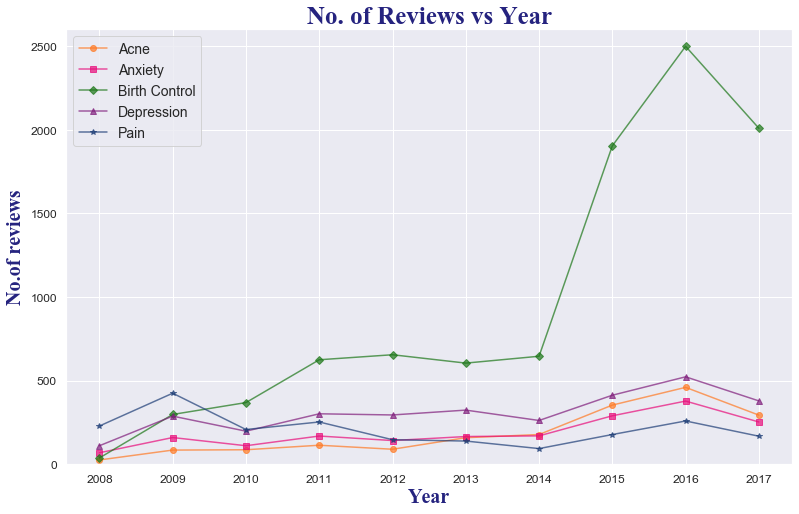

In [44]:
#Plotting the no.of reviews per year for the top 5 conditions

#It can be observed from the graph that the number of reviews for Birth Control drugs increased tremendously after 
#2014.

x=[i for i in range(0,10)]
fig,ax=plt.subplots()
colors=['#FF7923','#E80C7A','#1B7617','#7F1D7B','#1D3D76']
markers=['o','s','D','^','*']
for (cond,value),c,m in zip(cond_values.groupby(level=0),colors,markers):
    ax.plot(x,value,color=c,alpha=0.7,marker=m)
plt.ylim(0,2600)
plt.xticks(x,cond_values.index.get_level_values(1))
ax.set_title("No. of Reviews vs Year",color='#25237F',fontname='Times New Roman')
ax.set_xlabel("Year",fontname='Times New Roman',color='#25237F')
ax.set_ylabel("No.of reviews",fontname='Times New Roman',color='#25237F')
ax.legend(cond_values.index.get_level_values(0).unique(),fontsize=14,loc='upper left')
plt.show()

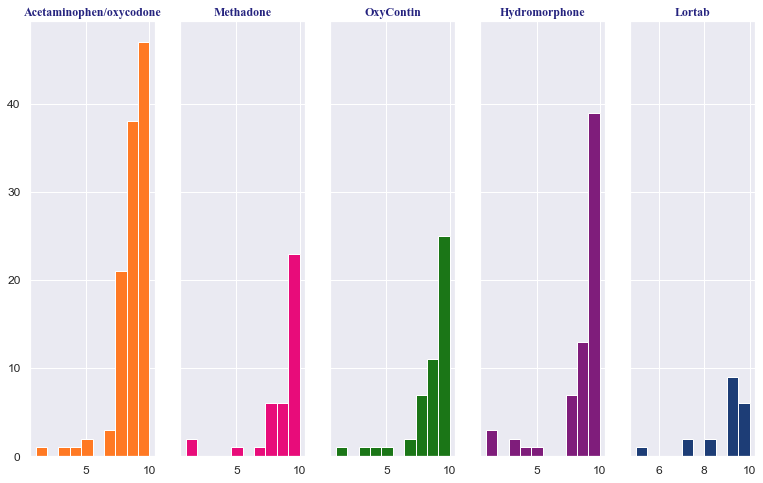

In [45]:
#Histogram of ratings for top 5 pain medications

fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,sharey=True)

best=sig_best.reset_index()
pain_drugs=best[best.condition=='Pain'][['drugName','rating']].nlargest(5,columns='rating')
pain=final_df[final_df.condition=='Pain']
p_drugs=pain[pain['drugName'].isin(pain_drugs.drugName)]

ax1.hist(p_drugs[p_drugs.drugName=='Acetaminophen / oxycodone']['rating'],color='#FF7923')
ax2.hist(p_drugs[p_drugs.drugName=='Methadone']['rating'],color='#E80C7A')
ax3.hist(p_drugs[p_drugs.drugName=='OxyContin']['rating'],color='#1B7617')
ax4.hist(p_drugs[p_drugs.drugName=='Hydromorphone']['rating'],color='#7F1D7B')
ax5.hist(p_drugs[p_drugs.drugName=='Lortab']['rating'],color='#1D3D76')

ax1.set_title('Acetaminophen/oxycodone',fontsize=12,color='#25237F',fontname='Times New Roman')
ax2.set_title('Methadone',fontsize=12,color='#25237F',fontname='Times New Roman')
ax3.set_title('OxyContin',fontsize=12,color='#25237F',fontname='Times New Roman')
ax4.set_title('Hydromorphone',fontsize=12,color='#25237F',fontname='Times New Roman')
ax5.set_title('Lortab',fontsize=12,color='#25237F',fontname='Times New Roman')

plt.show()

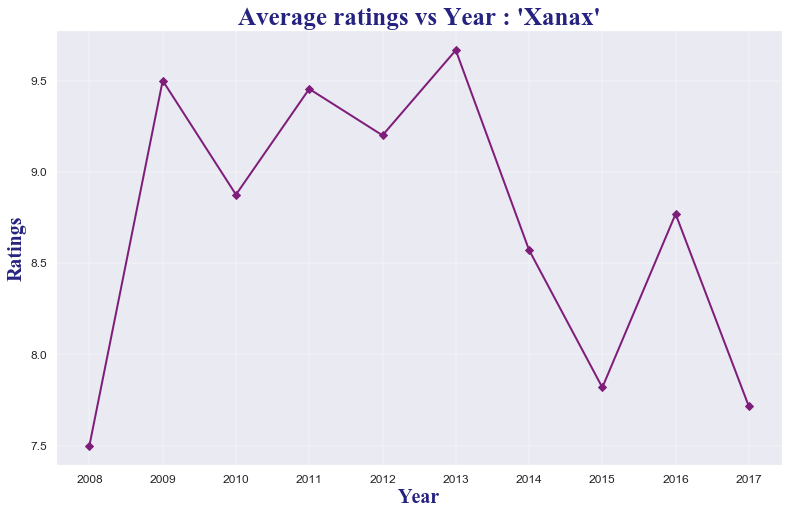

In [46]:
#Change in the average ratings of the popular drug 'Xanax'

drug=final_df[(final_df.drugName=='Xanax')&(final_df.condition=='Anxiety')][['year','rating']].groupby('year').mean()
fig,ax=plt.subplots()
x=list(range(0,10))
ax.plot(x,drug,color='#7F1D7B',linewidth=2,marker='D')
plt.xticks(x,drug.index)
ax.set_title("Average ratings vs Year : 'Xanax'",color='#25237F',fontname='Times New Roman')
ax.set_xlabel("Year",color='#25237F',fontname='Times New Roman')
ax.set_ylabel("Ratings",color='#25237F',fontname='Times New Roman')
ax.grid(linewidth=0.45,linestyle='-')

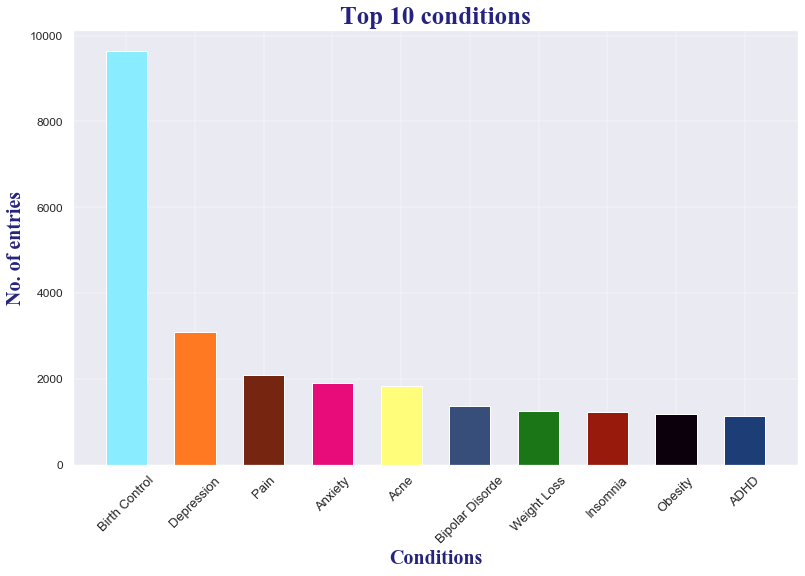

In [47]:
#Display the top 10 conditions

colors=['#8AECFF','#FF7923','#762610','#E80C7A','#FFFD7A','#374D7A','#1B7617','#981A0C','#0D000D','#1D3D76']
X=np.arange(0,10)
Y=df['condition'].value_counts().nlargest(10).values
fig,ax=plt.subplots()
ax.bar(X,Y, color=colors,width=0.6)
plt.xticks(X,df['condition'].value_counts().nlargest(10).index,fontsize=13)
ax.set_title("Top 10 conditions",color='#25237F',fontname='Times New Roman')
ax.set_xlabel("Conditions",fontname='Times New Roman',color='#25237F')
ax.set_ylabel("No. of entries",fontname='Times New Roman',color='#25237F')
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45)
ax.grid(linewidth=0.45,linestyle='-')

plt.show()

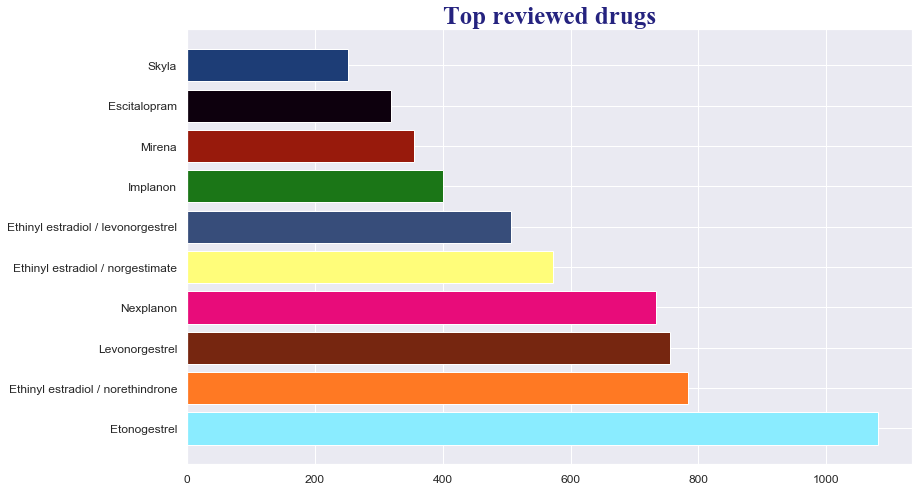

In [48]:
#Top 10 reviewed drugs

top_reviewed_drugs=final_df['drugName'].value_counts().nlargest(10)

plt.barh(top_reviewed_drugs.index,top_reviewed_drugs,color=colors)
plt.title("Top reviewed drugs",color='#25237F',fontname='Times New Roman')

plt.show()


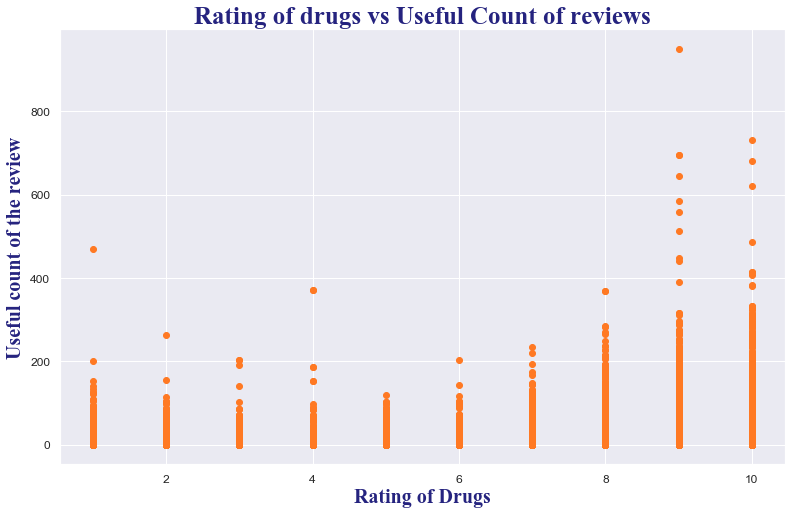

In [49]:
#Scatter plot of 'Ratings' and 'Usefulcounts'

x=final_df['rating'].values
y=final_df['usefulCount'].values

plt.scatter(x,y,color='#FF7923')
plt.title("Rating of drugs vs Useful Count of reviews",color='#25237F',fontname='Times New Roman')
plt.xlabel("Rating of Drugs",color='#25237F',fontname='Times New Roman')
plt.ylabel("Useful count of the review",color='#25237F',fontname='Times New Roman')
plt.show()